# SegNet CNN Model

## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def encoder_block(inputs, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    pooled = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    return pooled, x

def decoder_block(inputs, skip_features, filters):
    upsampled = layers.UpSampling2D((2, 2))(inputs)
    x = layers.concatenate([upsampled, skip_features])
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def Segnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1, s1 = encoder_block(inputs, 64)
    e2, s2 = encoder_block(e1, 128)
    e3, s3 = encoder_block(e2, 256)
    e4, s4 = encoder_block(e3, 512)
    e5, s5 = encoder_block(e4, 512)

    # Decoder
    d5 = decoder_block(e5, s5, 512)
    d4 = decoder_block(d5, s4, 512)
    d3 = decoder_block(d4, s3, 256)
    d2 = decoder_block(d3, s2, 128)
    d1 = decoder_block(d2, s1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(d1)

    model = models.Model(inputs, outputs)

    return model

In [ ]:
inputshape = (128, 128, 3)
numclasses = 1

In [ ]:
model = Segnet(inputshape, numclasses)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_150 (Conv2D)       │ (None, 128, 128, 64)   │          1,792 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_144   │ (None, 128, 128, 64)   │            256 │ conv2d_150[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_140 (ReLU)          │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_151 (Conv2D)       │ (None, 128, 128, 64)   │         36,928 │ re_lu_140[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_145   │ (None, 128, 128, 64)   │            256 │ conv2d_151[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_141 (ReLU)          │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 64, 64, 64)     │              0 │ re_lu_141[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_152 (Conv2D)       │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_146   │ (None, 64, 64, 128)    │            512 │ conv2d_152[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_142 (ReLU)          │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_153 (Conv2D)       │ (None, 64, 64, 128)    │        147,584 │ re_lu_142[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_147   │ (None, 64, 64, 128)    │            512 │ conv2d_153[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_143 (ReLU)          │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 32, 32, 128)    │              0 │ re_lu_143[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_154 (Conv2D)       │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_17[0][0] │
├──────────────────────

 Total params: 26,683,905 (101.79 MB)

 Trainable params: 26,672,129 (101.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Getting Train-Valid-Test Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

# TRAIN
trainimageNP = np.load("/content/drive/My Drive/MANDIBLE/train_img.npy")
trainmaskNP = np.load("/content/drive/My Drive/MANDIBLE/train_mask.npy")

# VALID
validimageNP = np.load("/content/drive/My Drive/MANDIBLE/valid_img.npy")
validmaskNP = np.load("/content/drive/My Drive/MANDIBLE/valid_mask.npy")

# TEST
testimageNP = np.load("/content/drive/My Drive/MANDIBLE/test_img.npy")
testmaskNP = np.load("/content/drive/My Drive/MANDIBLE/test_mask.npy")

In [ ]:
print(trainimageNP.shape)
print(trainmaskNP.shape)
print(validimageNP.shape)
print(validmaskNP.shape)
print(testimageNP.shape)
print(testmaskNP.shape)

(1626, 128, 128, 3)
(1626, 128, 128)
(465, 128, 128, 3)
(465, 128, 128)
(233, 128, 128, 3)
(233, 128, 128)


## Epoch Training

In [ ]:
lr = 1e-4
batchSize = 32
epochs = 25

In [ ]:
drive_path = '/content/drive/My Drive/MANDIBLE/models/segnet.keras'

In [ ]:
import time
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Compile the model
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Calculate steps per epoch and validation steps
stepsPerEpoch = len(trainimageNP) // batchSize
validationSteps = len(validimageNP) // batchSize

# Define callbacks
callbacks = [
    ModelCheckpoint(drive_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min")
]

# Record the start time
start_time = time.time()

# Train the model
history = model.fit(trainimageNP, trainmaskNP,
                    batch_size=batchSize,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validimageNP, validmaskNP),
                    validation_steps=validationSteps,
                    steps_per_epoch=stepsPerEpoch,
                    shuffle=True,
                    callbacks=callbacks
                    )

# Record the end time
end_time = time.time()

# Calculate the training duration
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8964 - loss: 0.2824
Epoch 1: val_loss improved from inf to 0.51978, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 691ms/step - accuracy: 0.8974 - loss: 0.2804 - val_accuracy: 0.8353 - val_loss: 0.5198 - learning_rate: 1.0000e-04
Epoch 2/25
 1/50 ━━━━━━━━━━━━━━━━━━━━ 7:36 9s/step - accuracy: 0.9727 - loss: 0.1096

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.51978 to 0.51610, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 565ms/step - accuracy: 0.9727 - loss: 0.1096 - val_accuracy: 0.8351 - val_loss: 0.5161 - learning_rate: 1.0000e-04
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9760 - loss: 0.0951
Epoch 3: val_loss improved from 0.51610 to 0.42766, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 629ms/step - accuracy: 0.9761 - loss: 0.0950 - val_accuracy: 0.8353 - val_loss: 0.4277 - learning_rate: 1.0000e-04
Epoch 4/25
 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - accuracy: 0.9824 - loss: 0.0723
Epoch 4: val_loss improved from 0.42766 to 0.42342, saving model to /content/drive/My Drive/MANDIBLE/models/segnet.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9824 - loss: 0.0723 - val_accuracy: 0.8351 - val_loss: 0.4234 - learning_rate: 1.0000e-04
Epoch 5/25
50/50 ━━━━━━━━

## Performance Visualization

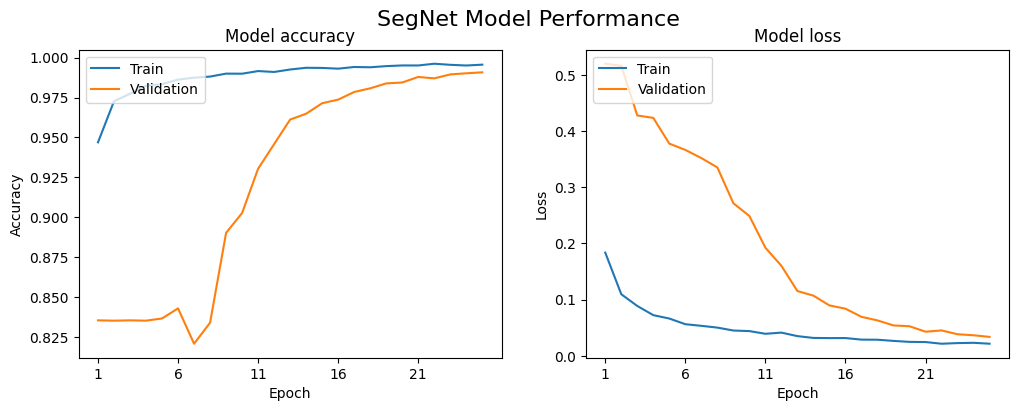

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Determine the number of epochs
epochs = len(history.history['accuracy'])
interval = 5

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'])
plt.plot(range(1, epochs + 1), history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.plot(range(1, epochs + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

# Add an overall title
plt.suptitle('SegNet Model Performance', fontsize=16)

plt.show()

## Evaluating on Test Set

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(drive_path)

test_loss, test_accuracy = best_model.evaluate(testimageNP, testmaskNP, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - accuracy: 0.9904 - loss: 0.0350
Test Loss: 0.03473267704248428
Test Accuracy: 0.9904465675354004
